In [21]:
'''
使用VS Code+jupyter notebook编译
使用Nvidia RTX3060 GPU进行训练
作者:张伟业
'''
import torch
print(torch.cuda.is_available())
print(torch.__version__)

True
2.1.1+cu121



基于BP算法，使用Numpy从零编程实现多层感知机（全连接）网络，利用波士顿房价数据集进行训练和测试。


从零构建全连接神经网络

In [22]:
import math
import numpy as np

1. 网络模型基类

In [23]:
class Module():
    def __init__(self, **kwargs):
        for key, value in kwargs.items(): setattr(self, key, value)
        # 默认为可训练状态
        self.training = True
        # 保存一些必要的数据用于反向传播
        self.storage = {}
    '''前向传播调用'''
    def __call__(self, x, **kwargs):
        self.storage.update({'x': x})
        x = self.forward(x, **kwargs)
        return x
    '''定义前向传播'''
    def forward(self):
        raise NotImplementedError('not to be implemented')
    '''定义反向传播'''
    def backward(self):
        raise NotImplementedError('not to be implemented')
    '''返回模型的名字'''
    def name(self):
        return self.__class__.__name__
    '''设置为训练状态'''
    def train(self, mode=True):
        def apply(module_dict, mode):
            for module in module_dict.values():
                if isinstance(module, dict):
                    apply(module, mode)
                else:
                    setattr(module, 'training', mode)
        module_dict = self.modules()
        apply(module_dict, mode)
    '''设置为测试状态'''
    def eval(self):
        self.train(mode=False)
    '''根据使用的优化器更新参数'''
    def update(self):
        raise NotImplementedError('not to be implemented')
    '''返回所有modules'''
    def modules(self):
        module_dict, attrs = {self.name(): self}, dir(self)
        for attr in attrs:
            value = getattr(self, attr)
            if isinstance(value, Module):
                module_dict[f'{self.name()}.{attr}'] = value.modules()
        return module_dict

2. 线性层

In [24]:
class Linear(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__(
            in_features=in_features, out_features=out_features, bias=bias
        )
        # 初始化权重
        thresh = 1 / math.sqrt(in_features)
        self.weight = np.random.uniform(
            -thresh, thresh, (in_features, out_features)
        )
        self.bias = np.zeros((1, out_features))
        # 初始化storage
        self.storage.update({
            'direction': {
                'weight': np.zeros(np.shape(self.weight)),
                'bias': np.zeros(np.shape(self.bias))
            },
        })
        # 取消bias
        if not bias: delattr(self, 'bias')
    '''定义前向传播'''
    def forward(self, x):
        if hasattr(self, 'bias'):
            # feats = x · weight + bias
            
            feats = np.dot(x, self.weight) + self.bias
        else:
            # feats = x · weight
            
            feats = np.dot(x, self.weight)
        print('forward is well')
        return feats
    '''定义反向传播'''
    def backward(self, accumulated_gradient):
        weight = self.weight
        if self.training:
            # 计算梯度
            # grad_w = x^T · accumulated_gradient
            # hint: get x from self.storage['x']
            
            x = self.storage['x']
            grad_w = np.dot(x.T, accumulated_gradient)
            grad_b = np.sum(accumulated_gradient, axis=0, keepdims=True)
            # 根据梯度更新weight
            results = self.update(self.weight, grad_w, self.storage['direction']['weight'])
            self.weight, self.storage['direction']['weight'] = results['params'], results['direction']
            # 根据梯度更新bias
            if hasattr(self, 'bias'):
                results = self.update(self.bias, grad_b, self.storage['direction']['bias'])
                self.bias, self.storage['direction']['bias'] = results['params'], results['direction']
        return accumulated_gradient.dot(weight.T)

3. 激活函数

In [25]:
class Sigmoid(Module):
    def __init__(self):
        super(Sigmoid, self).__init__()
    '''定义前向传播'''
    def forward(self, x):
        # calculate out = sigmoid(x)
        
        out = 1 / (1 + np.exp(-x))
        return out
    '''定义反向传播'''
    def backward(self, accumulated_gradient):
        z = self.forward(self.storage['x'])
        # calculate gradient with z
        
        gradient = z * (1 - z)
        return accumulated_gradient * gradient

class ReLU(Module):
    def __init__(self):
        super(ReLU, self).__init__()
    '''定义前向传播'''
    def forward(self, x):
        # calculate out = ReLU(x)
        
        out = np.maximum(0, x)
        return out
    '''定义反向传播'''
    def backward(self, accumulated_gradient):
        gradient = np.where(self.storage['x'] >= 0, 1, 0)
        return accumulated_gradient * gradient

class Softmax(Module):
    def __init__(self, dim=-1):
        super(Softmax, self).__init__(dim=dim)
    '''定义前向传播'''
    def forward(self, x):
        ex = np.exp(x - np.max(x, axis=self.dim, keepdims=True))
        return ex / np.sum(ex, axis=-1, keepdims=True)
    '''定义反向传播'''
    def backward(self, accumulated_gradient):
        p = self.forward(self.storage['x'])
        gradient = p * (1 - p)
        return accumulated_gradient * gradient

4. 损失函数

In [26]:
'''均方误差损失'''
class MSELoss():
    def __init__(self, reduction='mean'):
        assert reduction in ['sum', 'none', 'mean']
        self.reduction = reduction
        self.storage = {}
    '''定义前向传播'''
    def __call__(self, predictions, targets):
        self.storage.update({
            'predictions': predictions, 'targets': targets
        })
        # calculate MSE loss
        
        loss = np.mean((predictions - targets) ** 2)
        if self.reduction == 'none': return loss
        loss = getattr(loss, self.reduction)()
        return loss
    '''定义反向传播'''
    def backward(self):
        # calculate gradient of MSE loss
        # hint: get predictions and targets from self.storage['predictions'] and self.storage['targets']
        
        predictions, targets = self.storage['predictions'], self.storage['targets']
        gradient = 2 * (predictions - targets)
        if self.reduction == 'mean': gradient /= gradient.shape[0]
        return gradient

'''交叉熵损失'''
class CrossEntropy():
    def __init__(self, reduction='mean', eps=1e-12):
        assert reduction in ['sum', 'none', 'mean']
        self.reduction = reduction
        self.eps = eps
        self.storage = {}
    '''定义前向传播'''
    def __call__(self, predictions, targets):
        self.storage.update({
            'predictions': predictions, 'targets': targets
        })
        predictions = np.clip(predictions, self.eps, 1 - self.eps)
        # calculate cross entropy loss
        
        loss = -np.mean(targets * np.log(predictions))
        if self.reduction == 'none': return loss
        loss = getattr(loss, self.reduction)()
        return loss
    '''定义反向传播'''
    def backward(self):
        predictions, targets = self.storage['predictions'], self.storage['targets']
        predictions = np.clip(predictions, self.eps, 1 - self.eps)
        gradient = - (targets / predictions) + (1 - targets) / (1 - predictions)
        if self.reduction == 'mean': gradient /= gradient.shape[0]
        return gradient

5. 优化器基类

In [27]:
class BaseOptimizer():
    def __init__(self, **kwargs):
        for key, value in kwargs.items(): setattr(self, key, value)
    '''所有网络层都使用优化器的update函数'''
    def applyupdate(self, module_dict):
        for module in module_dict.values():
            if isinstance(module, dict):
                self.applyupdate(module)
            else:
                setattr(module, 'update', self.update)
    '''梯度更新函数'''
    def update(self, params, grads, direction):
        raise NotImplementedError('not to be implemented')
    '''参数更新'''
    def step(self):
        self.structure.backward(self.criterion.backward())

6. SGD优化器

In [28]:
class SGD(BaseOptimizer):
    def __init__(self, structure, criterion, learning_rate=0.01, momentum=0):
        super(SGD, self).__init__(
            structure=structure, criterion=criterion, learning_rate=learning_rate, momentum=momentum
        )
        # 所有网络层都使用优化器的update函数
        self.applyupdate(self.structure.modules())
    '''更新函数'''
    def update(self, params, grads, direction):
        direction = self.momentum * direction + (1 - self.momentum) * grads
        params = params - self.learning_rate * direction
        return {
            'params': params, 'direction': direction
        }

7. Sequential模型

In [29]:
'''定义Sequential模型'''
class Sequential(Module):
    def __init__(self, module_list=[], **kwargs):
        super(Sequential, self).__init__(**kwargs)
        self.module_dict = {}
        for idx, module in enumerate(module_list):
            self.module_dict.update({str(idx): module})
    '''添加模型'''
    def addmodule(self, name, module):
        self.module_dict.update({name: module})
    '''前向传播'''
    def forward(self, x):
        for module in self.module_dict.values():
            x = module(x)
        return x
    '''反向传播'''
    def backward(self, accumulated_gradient):
        for module in reversed(list(self.module_dict.values())):
            accumulated_gradient = module.backward(accumulated_gradient)
        return accumulated_gradient
    '''返回所有modules'''
    def modules(self):
        return self.module_dict

波士顿房价预测

In [30]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

1. 加载数据集

In [31]:
boston = datasets.load_boston()
train = boston.data
target = boston.target
target = np.expand_dims(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=123)

g:\myenvs\moon\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :f

In [32]:
data_df = pd.DataFrame(boston.data, columns=boston.feature_names)
data_df['target'] = boston.target
data_df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


2. 定义网络模型

In [33]:
hidden_dim = 32

model = Sequential()
# define the first layer as a linear layer, in_features = X_train.shape[1], out_features = hidden_dim

linear_layer1 = Linear(in_features = X_train.shape[1], out_features = hidden_dim)
model.addmodule('fc1', linear_layer1)
# define the activation function as ReLU

relu_layer = ReLU()
model.addmodule('relu', relu_layer)
# define the second layer as a linear layer, in_features = hidden_dim, out_features = 1 (the price)

linear_layer2 = Linear(in_features = hidden_dim, out_features = 1)
model.addmodule('fc2', linear_layer2)
# as this is a regression problem, we don't need a softmax layer

In [34]:
# define the loss function
criterion = MSELoss()
# define the optimizer
optimizer = SGD(model, criterion, 0.001, 0.9)

3. 训练网络

In [35]:
def train_epoch(model, criterion, optimizer, X_train, y_train, batch_size):
    model.train()
    losses = []
    for i in range(math.ceil(X_train[0].shape[0] / batch_size)):
        X_batch = X_train[i * batch_size: (i + 1) * batch_size]
        y_batch = y_train[i * batch_size: (i + 1) * batch_size]
        output = model(X_batch)
        loss = criterion(output, y_batch)
        optimizer.step()
        losses.append(loss)
    return losses

In [36]:
def test_epoch(model, X_test, y_test, batch_size):
    model.eval()
    losses = []
    for i in range(math.ceil(X_test.shape[0] / batch_size)):
        X_batch = X_test[i * batch_size: (i + 1) * batch_size]
        y_batch = y_test[i * batch_size: (i + 1) * batch_size]
        output = model(X_batch)
        loss = criterion(output, y_batch)
        losses.append(loss)
    return losses

In [37]:
num_epochs = 1000
batch_size = 64

train_loss_list, test_loss_list = [], []
for epoch in range(num_epochs):
    train_losses = train_epoch(model, criterion, optimizer, X_train, y_train, batch_size)
    test_losses = test_epoch(model, X_test, y_test, batch_size)
    train_loss = sum(train_losses) / len(train_losses)
    test_loss = sum(test_losses) / len(test_losses)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss}, Test Loss: {test_loss}')

forward is well
forward is well
forward is well
forward is well
forward is well
forward is well
Epoch: 1, Train Loss: 12162.261280297917, Test Loss: 2913070.032634695
forward is well
forward is well
forward is well
forward is well
forward is well
forward is well
Epoch: 2, Train Loss: 3194363.802829862, Test Loss: 614.3200129039325
forward is well
forward is well
forward is well
forward is well
forward is well
forward is well
Epoch: 3, Train Loss: 547.8751467670966, Test Loss: 628.0040370464917
forward is well
forward is well
forward is well
forward is well
forward is well
forward is well
Epoch: 4, Train Loss: 560.483611168316, Test Loss: 640.2595486019927
forward is well
forward is well
forward is well
forward is well
forward is well
forward is well
Epoch: 5, Train Loss: 571.7870700430448, Test Loss: 651.193241101083
forward is well
forward is well
forward is well
forward is well
forward is well
forward is well
Epoch: 6, Train Loss: 581.8800566264106, Test Loss: 660.9080556738899
forwa

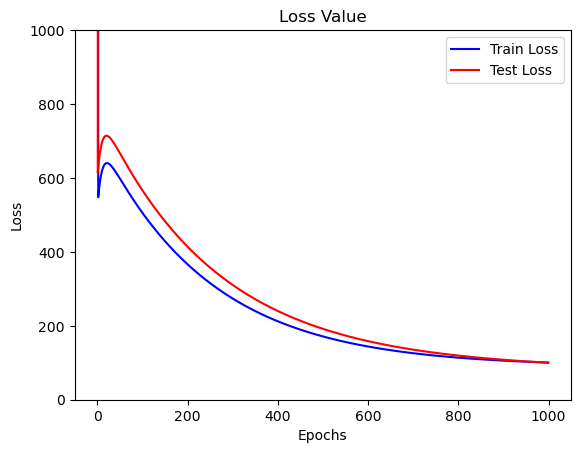

In [38]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, color='b', label='Train Loss')
plt.plot(test_loss_list, color='r', label='Test Loss')
plt.ylim((0, 1000))
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.title('Loss Value')
plt.show()